<a href="https://colab.research.google.com/github/OsyaginVictor/Determining-the-age-of-buyers/blob/main/Determining_the_age_of_buyers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение возраста покупателей

Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    Контролировать добросовестность кассиров при продаже алкоголя.

## Исследовательский анализ данных

In [ ]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
df = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
print('Данные')
display(df.head(8))
print('\n')
print('Размер датасета:', df.shape)
print('\n')
print('Информация\n')
print(df.info())
print('\n')
print('Описание\n')
print(df.describe())

Данные


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43




Размер датасета: (7591, 2)


Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


Описание

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


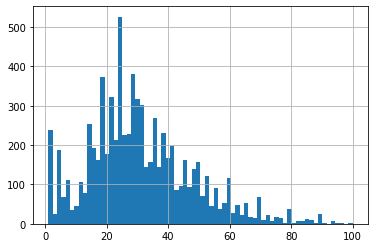

In [ ]:
df['real_age'].hist(bins=70);

Из анализа графика видно, что большинство изображений относятся к людям в возрасте от 20 до 40 лет.

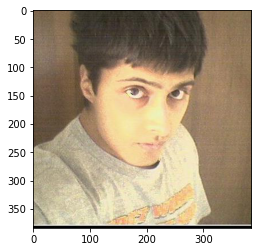

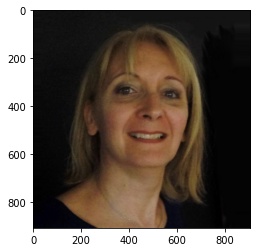

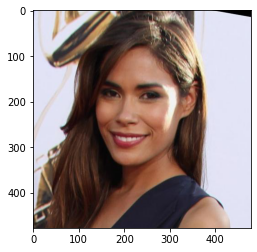

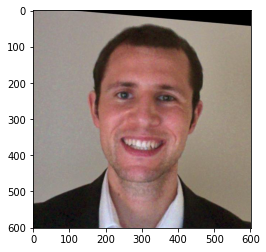

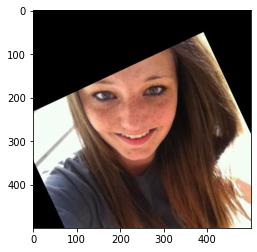

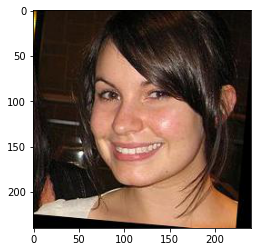

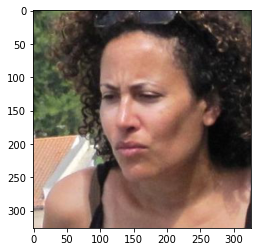

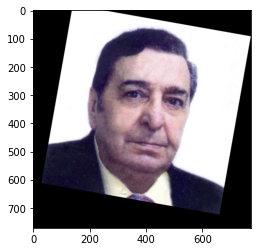

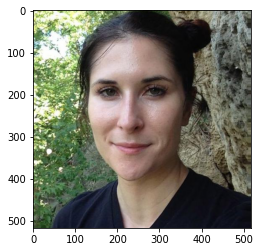

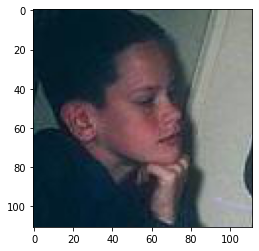

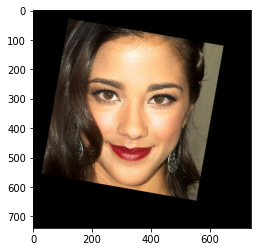

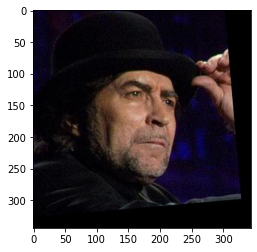

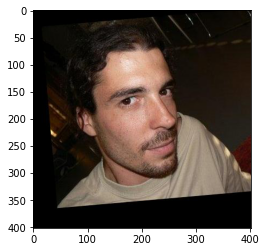

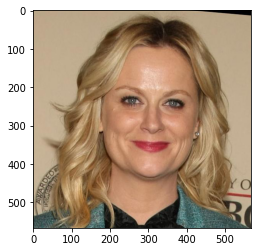

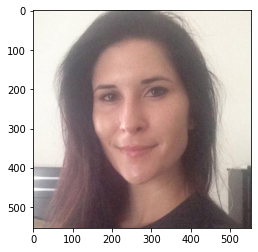

In [ ]:
photo = os.listdir('/datasets/faces/final_files/')
for i in random.sample(images, k=15):

    photo = Image.open('/datasets/faces/final_files/' + i)
    plt.imshow(np.array(photo))
    plt.show()

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```
Train for 356 steps, validate for 119 steps

Epoch 1/10 2022-09-11 17:01:35.624456: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10 2022-09-11 17:01:36.083992: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7 356/356 - 64s - loss: 271.8817 - mae: 12.0045 - val_loss: 836.7846 - val_mae: 23.8495

Epoch 2/10 356/356 - 42s - loss: 91.0972 - mae: 7.2597 - val_loss: 150.9057 - val_mae: 9.1005

Epoch 3/10 356/356 - 43s - loss: 62.9209 - mae: 6.0141 - val_loss: 95.7406 - val_mae: 7.6349

Epoch 4/10 356/356 - 43s - loss: 46.9962 - mae: 5.2095 - val_loss: 77.0721 - val_mae: 6.5062

Epoch 5/10 356/356 - 43s - loss: 36.7084 - mae: 4.6392 - val_loss: 84.2134 - val_mae: 6.8152

Epoch 6/10 356/356 - 44s - loss: 28.5118 - mae: 4.1317 - val_loss: 135.5684 - val_mae: 8.9295

Epoch 7/10 356/356 - 46s - loss: 23.7383 - mae: 3.7069 - val_loss: 105.2624 - val_mae: 7.6975

Epoch 8/10 356/356 - 47s - loss: 17.5736 - mae: 3.2252 - val_loss: 78.3782 - val_mae: 6.8026

Epoch 9/10 356/356 - 47s - loss: 14.6301 - mae: 2.9335 - val_loss: 67.3527 - val_mae: 6.2359

Epoch 10/10 356/356 - 46s - loss: 12.8221 - mae: 2.7161 - val_loss: 67.5433 - val_mae: 6.1607 WARNING:tensorflow:sample_weight modes were coerced from ... to
['...'] 119/119 - 11s - loss: 67.5433 - mae: 6.1607 Test MAE: 6.1607

```

## Анализ обученной модели

Наша задача заключалась в обучении остаточной нейронной сети ResNet с использованием аугментации данных (горизонтальный поворот) с целью достижения значения средней абсолютной ошибки MAE на тестовой выборке, не превышающего 8. После обучения модели за 10 эпох мы добились MAE равного 6.16 и функции потерь 67.5. Модель не переобучилась, так как как показатели как на обучающей выборке, так и на тестовой, постоянно улучшались. В результате мы можем использовать данную модель для определения возраста покупателей. Однако учитывая, что допущенная нами погрешность в 6 лет может быть существенной для проверки возраста при покупке алкоголя, рекомендуется проводить более тщательную проверку возраста в присутствии человека, чтобы снизить риски возникновения ошибок с высокими экономическими потерями для бизнеса.